# Historical shapes
Existence of the `gtfs_schedule_type2.shapes` table. Check out if this gives us what we need?

[GH issue](https://github.com/cal-itp/data-infra/issues/1210)

In [1]:
import datetime as dt
import geopandas as gpd
import os
import pandas as pd

os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
from siuba import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
SELECTED_DATE = dt.date(2021, 10, 22)

# Is this the correct query to use though?
# Perhaps this isn't service date?
shapes = (tbl.gtfs_schedule_type2.shapes()
 >> filter(_.calitp_itp_id==182)
 >> filter(_.calitp_extracted_at <= SELECTED_DATE, 
           _.calitp_deleted_at >= SELECTED_DATE)
)

In [ ]:
# May need to add in fact_daily_trips
# Does query below need to have a trip_key or stop_key?
trip_cols = ["calitp_itp_id", "route_id", "shape_id"]

dim_trips = (tbl.views.gtfs_schedule_dim_trips()
             >> select(*trip_cols, _.trip_key)
             >> distinct()
            )

trips = (tbl.views.gtfs_schedule_fact_daily_trips()
         >> filter(_.service_date == SELECTED_DATE, 
                   _.is_in_service==True)
         >> filter(_.calitp_itp_id==182)
         >> select(_.trip_key, _.service_date)
         >> inner_join(_, dim_trips, on = "trip_key")
         >> select(*trip_cols)
         >> distinct()
         >> collect()
        )

In [ ]:
shapes2 = (shapes 
           >> select(_.calitp_itp_id, _.shape_id)
           >> distinct()
           >> collect()
          )

In [ ]:
m1 = pd.merge(
    shapes2,
    trips,
    on = ["calitp_itp_id", "shape_id"],
    how = "outer",
    validate = "1:1",
    indicator=True
)

In [ ]:
m1._merge.value_counts()

In [ ]:
dim_stop_times = (
    tbl.views.gtfs_schedule_dim_stop_times()
    >> filter(_.calitp_itp_id==182)
    >> select(_.calitp_itp_id, _.calitp_url_number,
             _.trip_id, _.stop_id, _.stop_sequence)
    >> distinct()
    >> collect()
)

In [ ]:
dim_stops = (
    tbl.views.gtfs_schedule_dim_stops() 
    >> filter(_.calitp_itp_id==182)
    >> select(_.calitp_itp_id, _.calitp_url_number, 
              _.stop_id, _.stop_lon, _.stop_lat)
    >> distinct()
    >> collect()
)
             

In [ ]:
dim_stop_times.head(2)

In [ ]:
m2 = pd.merge(
    # this is at trip-level
    dim_stop_times,
    # Some stop_ids have different lat/lon...slightly different
    (dim_stops
     .sort_values(["calitp_itp_id", "calitp_url_number", 
                   "stop_id", "stop_lon"])
     .drop_duplicates(subset=["calitp_itp_id", "calitp_url_number", "stop_id"])
    ),
    on = ["calitp_itp_id", "calitp_url_number", "stop_id"],
    how = "outer",
    # m:1 because dim_stop_times is trip_level, so stop_id shows up multiple times
    # But, force stop lat/lon to be unique, so it can be m:1 merge
    validate = "m:1",
    indicator=True
)

In [ ]:
m2._merge.value_counts()

In [ ]:
stop_info_on_day = (
    # Trips table has shape_id
    tbl.views.gtfs_schedule_dim_trips()
    >> select(_.calitp_itp_id, _.calitp_url_number, _.shape_id, 
              _.trip_id)
    >> distinct()
    # Attach historical shape_id
    >> inner_join(_, shapes, 
                  ["calitp_itp_id", "calitp_url_number", "shape_id"])
    # dim_stop_times has the stop_id and stop_sequence
    >> inner_join(_, 
                  (tbl.views.gtfs_schedule_dim_stop_times()
                   >> select(_.calitp_itp_id, _.calitp_url_number, 
                             _.trip_id, _.stop_id, _.stop_sequence
                            )
                  ), on = ["calitp_itp_id", "calitp_url_number", "trip_id"]
                 )
    # dim_stops has the stop_id and lat/lon
    >> inner_join(_,
                  (tbl.views.gtfs_schedule_dim_stops() 
                   >> select(_.calitp_itp_id, _.calitp_url_number, 
                             _.stop_id, _.stop_lon, _.stop_lat)
                  ), on = ["calitp_itp_id", "calitp_url_number", "stop_id"]
     )
)

In [ ]:
stop_info_on_day


In [10]:
from calitp.tables import tbl
from calitp import query_sql
from siuba import *

import datetime as dt


table = query_sql(
    '''
    with lat_long as (
        SELECT 
            calitp_itp_id,
            calitp_url_number,
            calitp_extracted_at,
            shape_id,
            shape_pt_sequence,
            calitp_deleted_at,

        ST_GEOGPOINT(CAST(shape_pt_lon AS FLOAT64), CAST(shape_pt_lat AS FLOAT64)) as pt_geom
        FROM `cal-itp-data-infra.gtfs_schedule_type2.shapes`
        WHERE
            calitp_itp_id = 182 AND calitp_extracted_at <= '2021-10-22'
            AND calitp_deleted_at > '2021-10-22'
        #LIMIT 100
    )

    SELECT 
        calitp_itp_id,
        calitp_url_number,
        shape_id,
        calitp_extracted_at,
        calitp_deleted_at,
        ST_MAKELINE(ARRAY_AGG(pt_geom ORDER BY shape_pt_sequence)) as line_geom
    FROM lat_long
    GROUP BY 
        calitp_itp_id,
        calitp_url_number,
        calitp_extracted_at,
        calitp_deleted_at,
        shape_id
    '''
)

In [12]:
len(table)

737

In [28]:
type(table)

pandas.core.frame.DataFrame

In [29]:
table

,calitp_itp_id,calitp_url_number,shape_id,calitp_extracted_at,calitp_deleted_at,line_geom
0,182,0,3440046_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.3938392132 33.7485916172, -118..."
1,182,0,600163_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.2506765752 34.0457890895, -118..."
2,182,0,1060039_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.1708846075 34.0608701608, -118..."
3,182,0,2330163_SEPT21,2021-09-11,2021-12-18,MULTILINESTRING((-118.4662137534 34.1529898627...
4,182,0,7610069_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.4686209771 34.0737097818, -118..."
...,...,...,...,...,...,...
732,182,0,1640064_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.5445848907 34.1866093989, -118..."
733,182,0,780440_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.1840029609 34.0860782363, -118..."
734,182,0,21103_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.302979346 34.0981244752, -118...."
735,182,0,2600263_SEPT21,2021-09-11,2021-12-18,"LINESTRING(-118.1505729473 34.1575287701, -118..."


In [49]:
table = table.rename(columns = {"line_geom": "geometry"})

t1 = gpd.GeoDataFrame(table, crs="EPSG:4326")

t2 = t1[t1.shape_id.str.contains('720')]

/tmp/ipykernel_971/1209514510.py:3: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  t1 = gpd.GeoDataFrame(table, crs="EPSG:4326")


TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

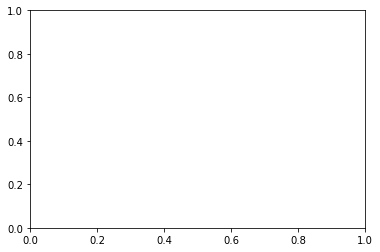

In [56]:
t2.plot()

In [53]:
from shared_utils import geography_utils

metro = geography_utils.make_routes_shapefile(ITP_ID_LIST = [182])

In [ ]:
metro2 = metro[metro.shape_id.str.contains('720')]

In [ ]:
metro2.plot()